<IPython.core.display.Javascript object>


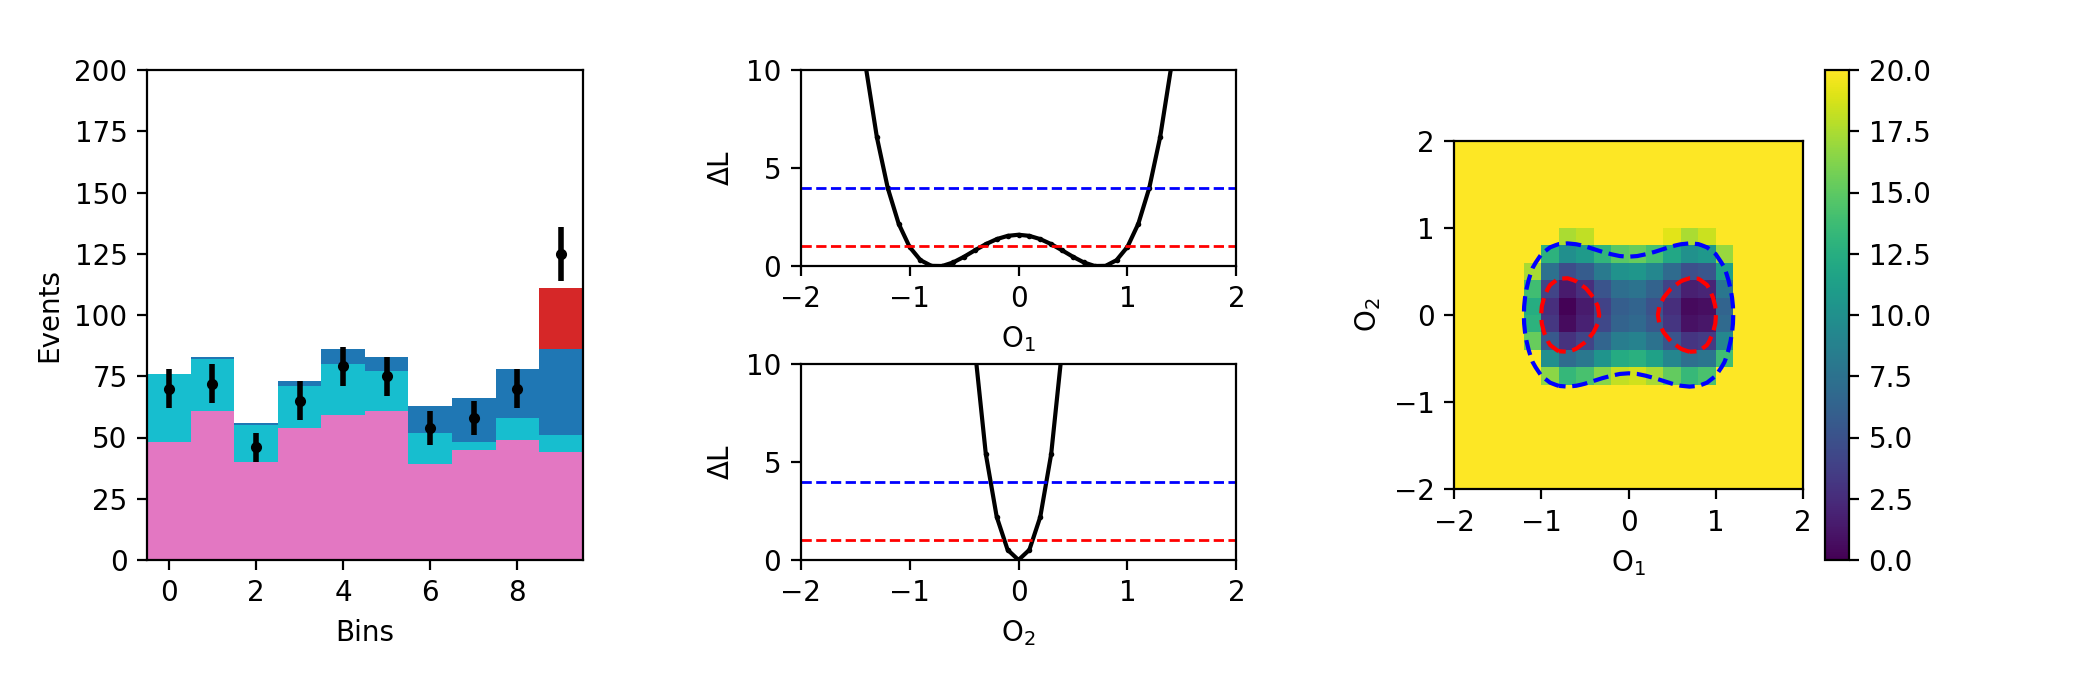

In [58]:
%matplotlib notebook
import numpy as np
import math
from collections import OrderedDict
from scipy import stats
from ipywidgets import *
import matplotlib.pyplot as plt

wcmin = -2.0
wcmax = 2.0
wcstep = (wcmax-wcmin)/40.0
wcx = list(np.arange(wcmin, wcmax, wcstep)); wcx += [wcx[-1]+wcstep]

lh2dmin = 0.0
lh2dmax = 20.0
lh1dmin = 0.0
lh1dmax = 10.0

cl68_1d = 1.00
cl95_1d = 4.00
cl68_2d = 2.30
cl95_2d = 6.18

counts, bins = {}, {}
buff = {}
nBins = 10
nev = OrderedDict({'bkg3': 50000, 'bkg2': 5000, 'bkg1': 5000, 'sig': 5000})
cols = OrderedDict({'bkg3': 'tab:pink', 'bkg2': 'tab:cyan', 'bkg1': 'tab:blue', 'sig': 'tab:red'})
syst = OrderedDict({'bkg3': [{'bkg3norm_normsys': 1.10}, {'shape3': list(np.random.uniform(0.85, 1.15, nBins))}], \
                    'bkg2': [{'bkg2norm_normsys': 1.10}], \
                    'bkg1': [{'bkg1norm_normsys': 1.10}, {'shape1': list(np.random.uniform(0.7, 1.3, nBins))}], \
                    'sig': [{'normsys': 1.20}, {'shape': list(np.random.uniform(0.8, 1.2, nBins))}, {'rate_rateparam': 1.5}],
                   })

nproc = len(nev.keys())
(counts['tot'], bins['tot']) = np.histogram([], bins=nBins, range=(0, 10))

for p in nev.keys():
    
    sc = 1.0
    if p in ['bkg2']: sc = 0.05
    elif p in ['bkg1']: sc = 0.02
    elif p in ['bkg3']: sc = 0.01
    elif p in ['sig']: sc = 0.005
    
    nevsc = int(nev[p]*sc)
    
    if p in ['sig']: data = np.random.exponential(0.01, nevsc)
    elif p in ['bkg1']: data = np.random.exponential(2, nevsc)
    elif p in ['bkg2']: data = np.random.exponential(10, nevsc)
    elif p in ['bkg3']: data = np.random.uniform(0., nBins, nevsc)
    else: continue
    if p not in ['sig', 'bkg1']: (counts[p], bins[p]) = np.histogram(data, bins=nBins, range=(0, 10))
    else: (counts[p], bins[p]) = np.histogram([nBins-d for d in data], bins=nBins, range=(0, 10))
    integ = sum(np.diff(bins[p])*counts[p])
    
    hsyst = counts[p].copy()
       
    if p in syst.keys():
        for syss in syst[p]:
            for k, v in syss.items():
                if 'norm' in k:
                    for ib in range(nBins):                        
                        nom = hsyst[ib]
                        shifted = nom + np.random.normal(0., hsyst[ib]*(v-1.0), 1)[0]
                        shifted = shifted if shifted > 0 else 0.
                        hsyst[ib] = shifted
                elif 'rate' in k:
                    for ib in range(nBins):
                        nom = hsyst[ib]
                        shifted = nom*v
                        hsyst[ib] = shifted
                elif 'shape' in k:
                    hsystup = counts[p].copy()
                    hsystdo = counts[p].copy()
                    for j in [-1, 1]:
                        for ib in range(nBins):
                            nomm = counts[p][ib]
                            shifted = abs(nomm*v[ib]-nomm)*j+nomm
                            shifted = shifted if shifted > 0 else 0.
                            if j == -1: hsystdo[ib] = shifted
                            else: hsystup[ib] = shifted
                        for ib in range(nBins):
                            nom = hsyst[ib]
                            shifted = abs(nom*v[ib]-nom)*j+nom
                            shifted = shifted if shifted > 0 else 0.
                            hsyst[ib] = shifted
                else:
                    print('Uknown systematics type found')
                    sys.exit()

    counts['tot'] += hsyst
    
data_obs, data_obs_err = counts['tot'].copy(), counts['tot'].copy()
for ib in range(nBins):
    v = data_obs[ib]
    if v > 3.0:
        vg = int(np.random.normal(loc=v, scale=math.sqrt(v), size=1)[0])
        err = math.sqrt(vg)
    else: 
        vg = np.random.poisson(lam=v, size=1)[0]
        err = vg-stats.poisson.interval(0.68, vg)[0]
    data_obs[ib] = vg
    data_obs_err[ib] = err
integ = sum(np.diff(bins['tot'])*data_obs)

fig = plt.figure('EFT fit')
fig.set_size_inches(10.5, 3.5)
ax = plt.GridSpec(2, 3, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(ax[:, 0])
ax2 = plt.subplot(ax[0, 1])
ax3 = plt.subplot(ax[1, 1])
ax4 = plt.subplot(ax[:, 2])
plt.subplots_adjust(left=0.07, right=0.9, top=0.9, bottom=0.2)

def plotHist(counts):    
    lbins = bins['tot'][:-1]
    xbins = [b-0.5 for b in bins['tot']]
    weights = np.vstack([counts[p] for p in nev.keys()]).transpose()
    data = np.vstack([lbins for i in range(nproc)]).transpose()
    colors = [cols[p] for p in nev.keys()]
    ax1.hist(data, bins=xbins, weights=weights, stacked=True, color=colors, lw=2, alpha=1.0, label=nev.keys())
    ax1.errorbar(lbins, data_obs, yerr=data_obs_err, fmt='.', color='black', lw=2, alpha=1.0)
    
def calcChi2(npoi, pred, prederr, data, dataerr):
    prederr = [0.0 for v in range(len(prederr))]
    xi2 = chi2(npoi, pred, prederr, data, dataerr)
    return xi2

def bestFit(xi2):
    bf = 1e+10
    for v in xi2:
        if v < bf:
            bf = v
    return bf
    
def plotLH(wc1, wc2, lh, ltype='base', ftype='wc1-1d'):
    sc = None
    if '2d' not in ftype:
        if ltype == 'base':
            color = 'black'
            sz = 1
            if ftype == 'wc1-1d':
                ax2.plot(wc1, lh, 'o-', color=color, markersize=sz)
            elif ftype == 'wc2-1d': 
                ax3.plot(wc2, lh, 'o-', color=color, markersize=sz)
        else:
            color = 'red'
            sz = 20
            if ftype == 'wc1-1d': sc = ax2.scatter(wc1, lh, color=color, s=sz)
            elif ftype == 'wc2-1d': sc = ax3.scatter(wc2, lh, color=color, s=sz)
    elif ftype != 'wc-2d': 
        h = ax4.hist2d(wc1, wc2, bins=20, weights=lh, vmin=lh2dmin, vmax=lh2dmax)
        fig.colorbar(h[3], ax=ax4)
        lh2d = []
        for wc2i, wc2v in enumerate(wcx):
            lh2d.append([])
            for wc1i, wc1w in enumerate(wcx):
                lh2d[-1].append(lh[wc1i*len(wcx)+wc2i])
        ax4.contour(wcx, wcx, lh2d, [cl68_1d, cl95_1d], alpha=1.0, colors=['red', 'blue'], linestyles='dashed')
    else:
        sc = ax4.scatter(wc1, wc2, color='red', s=20)
    return sc

def chi2(npoi, exp, experr, data, dataerr):
    f = 0.0
    for i in range(npoi):
        err2 = experr[i]**2+dataerr[i]**2
        f += (data[i]-exp[i])**2/err2
    return f

def param(wc, ibin, t = 'xsec'):
    if t == 'linshape': return wc*ibin
    elif t == 'quadshape': return wc*wc*ibin
    elif t == 'quad': return wc*wc
    elif t == 'lin': return wc
    elif t == 'full': return wc*wc+wc
    return wc

def applyEFT(npoi, csm, ceft1d_wc1, ceft1d_wc2, ceft2d, wc1, wc2):
    for p in nev.keys():
        w1c, w2c = 0.0, 0.0
        if p in ['sig']: w1c = param(wc1, 0, 'quad')
        elif p in ['bkg1', 'bkg2']: w2c = param(wc2, 0, 'quad')
        csm0[p] = [v for iv, v in enumerate(csm[p])]
        ceft1d_wc1[p] = [v+v*w1c for iv, v in enumerate(csm[p])]
        ceft1d_wc2[p] = [v+v*w2c for iv, v in enumerate(csm[p])]
        ceft2d[p] = [v+v*w1c+w2c for iv, v in enumerate(csm[p])]
    ptot_csm = list(np.zeros(len(csm0['sig'])))
    ptot1d_wc1 = list(np.zeros(len(ceft1d_wc1['sig'])))
    ptot1d_wc2 = list(np.zeros(len(ceft1d_wc2['sig'])))
    ptot2d = list(np.zeros(len(ceft2d['sig'])))
    for p in nev.keys():
        for ip in range(npoi):
            ptot_csm[ip] += csm0[p][ip]
            ptot1d_wc1[ip] += ceft1d_wc1[p][ip]
            ptot1d_wc2[ip] += ceft1d_wc2[p][ip]
            ptot2d[ip] += ceft2d[p][ip]
    return csm0, ceft1d_wc1, ceft1d_wc2, ceft2d, ptot_csm, ptot1d_wc1, ptot1d_wc2, ptot2d

def setFig():
    ax1.set_xlim([bins['tot'][0]-0.5, bins['tot'][-1]-0.5])
    ax1.set_ylim([0, 200])
    ax2.set_xlim([wcmin, wcmax])
    ax2.set_ylim([lh1dmin, lh1dmax])
    ax3.set_xlim([wcmin, wcmax])
    ax3.set_ylim([lh1dmin, lh1dmax])
    ax4.set_xlim([wcmin, wcmax])
    ax4.set_ylim([wcmin, wcmax])
    ax1.set_xlabel('Bins')
    ax1.set_ylabel('Events')
    ax2.set_xlabel('$\mathrm{O_{1}}$')
    ax2.set_ylabel('$\mathrm{\Delta L}$')
    ax3.set_xlabel('$\mathrm{O_{2}}$')
    ax3.set_ylabel('$\mathrm{\Delta L}$')
    ax4.set_xlabel('$\mathrm{O_{1}}$')
    ax4.set_ylabel('$\mathrm{O_{2}}$')
    ax2.hlines(y=cl68_1d, color='red', xmin=wcmin, xmax=wcmax, linestyle='--', linewidth=1)
    ax2.hlines(y=cl95_1d, color='blue', xmin=wcmin, xmax=wcmax, linestyle='--', linewidth=1)
    ax3.hlines(y=cl68_1d, color='red', xmin=wcmin, xmax=wcmax, linestyle='--', linewidth=1)
    ax3.hlines(y=cl95_1d, color='blue', xmin=wcmin, xmax=wcmax, linestyle='--', linewidth=1)
    ax4.set_aspect('equal', adjustable='box')

plotHist(counts)
ceft1d_wc1 = counts.copy()
ceft1d_wc2 = counts.copy()
ceft2d = counts.copy()
csm0 = counts.copy()
npoi = len(ceft2d['sig'])
counts_init = counts

lh_wc1, lh_wc2, lh_2d = [], [], []
lh_wc0 = calcChi2(npoi, ptot_csm, data_obs_err, data_obs, data_obs_err)
for wc in wcx:
    csm0, ceft1d_wc1, ceft1d_wc2, ceft2d, ptot_csm, ptot1d_wc1, ptot1d_wc2, ptot2d = applyEFT(npoi, counts_init, ceft1d_wc1, ceft1d_wc2, ceft2d, wc, 0.0)
    lh_wc1.append(calcChi2(npoi, ptot1d_wc1, data_obs_err, data_obs, data_obs_err))
    csm0, ceft1d_wc1, ceft1d_wc2, ceft2d, ptot_csm, ptot1d_wc1, ptot1d_wc2, ptot2d = applyEFT(npoi, counts_init, ceft1d_wc1, ceft1d_wc2, ceft2d, 0.0, wc)
    lh_wc2.append(calcChi2(npoi, ptot1d_wc2, data_obs_err, data_obs, data_obs_err))
bf_wc1 = bestFit(lh_wc1)
lh_wc1 = [v-bf_wc1 for v in lh_wc1]
bf_wc2 = bestFit(lh_wc2)
lh_wc2 = [v-bf_wc2 for v in lh_wc2]
    
wc1_2d, wc2_2d = [], []
for w1 in wcx:
    for w2 in wcx:
        wc1_2d.append(w1)
        wc2_2d.append(w2)
for wci in range(len(wc1_2d)):
    csm0, ceft1d_wc1, ceft1d_wc2, ceft2d, ptot_csm, ptot1d_wc1, ptot1d_wc2, ptot2d = applyEFT(npoi, counts_init, ceft1d_wc1, ceft1d_wc2, ceft2d, wc1_2d[wci], wc2_2d[wci])
    lh_2d.append(calcChi2(npoi, ptot2d, data_obs_err, data_obs, data_obs_err))
bf_2d = bestFit(lh_2d)
lh_2d = [v-bf_2d for v in lh_2d]
_ = plotLH(wcx, None, lh_wc1, ltype='base', ftype='wc1-1d')
_ = plotLH(None, wcx, lh_wc2, ltype='base', ftype='wc2-1d')
_ = plotLH(wc1_2d, wc2_2d, lh_2d, ltype='base', ftype='wc2d')
setFig()

def update(wc1 = 0.0, wc2 = 0.0):
    if buff:
        buff['wc1'].remove()
        buff['wc2'].remove()
        buff['2d'].remove()
        buff.clear()
    ceft1d_wc1 = counts.copy()
    ceft1d_wc2 = counts.copy()
    ceft2d = counts.copy()
    ax1.clear()
    setFig()
    npoi = len(ceft2d['sig'])
    
    csm0, ceft1d_wc1, ceft1d_wc2, ceft2d, ptot_csm, ptot1d_wc1, ptot1d_wc2, ptot2d = applyEFT(npoi, counts_init, ceft1d_wc1, ceft1d_wc2, ceft2d, wc1, 0.0)
    lh_wc1 = calcChi2(npoi, ptot1d_wc1, data_obs_err, data_obs, data_obs_err)
    lh_wc1 -= bf_wc1
    sc = plotLH([wc1], None, [lh_wc1], ltype='meas', ftype='wc1-1d')
    buff['wc1'] = sc
    
    csm0, ceft1d_wc1, ceft1d_wc2, ceft2d, ptot_csm, ptot1d_wc1, ptot1d_wc2, ptot2d = applyEFT(npoi, counts_init, ceft1d_wc1, ceft1d_wc2, ceft2d, 0.0, wc2)
    lh_wc2 = calcChi2(npoi, ptot1d_wc2, data_obs_err, data_obs, data_obs_err)
    lh_wc2 -= bf_wc2
    sc = plotLH(None, [wc2], [lh_wc2], ltype='meas', ftype='wc2-1d')
    buff['wc2'] = sc
    
    csm0, ceft1d_wc1, ceft1d_wc2, ceft2d, ptot_csm, ptot1d_wc1, ptot1d_wc2, ptot2d = applyEFT(npoi, counts_init, ceft1d_wc1, ceft1d_wc2, ceft2d, wc1, wc2)
    lh_2d = calcChi2(npoi, ptot2d, data_obs_err, data_obs, data_obs_err)
    lh_2d -= bf_2d
    plotHist(ceft2d)
    sc = plotLH([wc1], [wc2], [lh_2d], ltype='meas', ftype='wc-2d')
    buff['2d'] = sc
    

In [52]:
interact(update, wc1=widgets.FloatSlider(min=wcmin, max=wcmax, step=wcstep, value=0.0, continuous_update=True, description='O1'), 
         wc2=widgets.FloatSlider(min=wcmin, max=wcmax, step=wcstep, value=0.0, continuous_update=True, description='O2'));

interactive(children=(FloatSlider(value=0.0, description='O1', max=2.0, min=-2.0), FloatSlider(value=0.0, desc…